In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import jax
import jax.numpy as jnp
from jax import grad
import matplotlib.pyplot as plt
from jax import random
import pandas as pd
from scipy.optimize import minimize
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

FS = (8, 4)  # figure size
RS = 124  # random seed

In [2]:
#X, y = load_breast_cancer(return_X_y=True)
#n_feat = X.shape[1]
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.25, stratify=y, random_state=RS
#)
#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_s = scaler.transform(X_train)
#X_test_s = scaler.transform(X_test)

In [3]:
#simulate data
def price_sensitivity_curve(r, a, b):
    # a: slope
    # b: horizontal shift
    # scaling to (0,1) space
    r = a*20*(r-0.5-b)
    return 1-(1 / (1 + jnp.exp(-r)))

def simulate_dataset(N, features, price_list, price_sensitivity_parms, seed):
    
    rng_f, rng_p, rng_s = random.split(jax.random.PRNGKey(seed), num=3)

    random_indices_feature = jax.random.randint(rng_f, shape=(N,), minval=0, maxval=features.shape[0])
    array_feature = jnp.array([features[i] for i in random_indices_feature])
    array_feature1 = jnp.array([i[0] for i in array_feature])
    array_feature2 = jnp.array([i[1] for i in array_feature])

    random_indices_price = jax.random.randint(rng_p, shape=(N,), minval=0, maxval=len(price_list))
    array_price = jnp.array([price_list[i] for i in random_indices_price])

    array_client_group = [0 if jnp.all(f == jnp.asarray([0, 1])) else 1 for f in array_feature]

    array_p = jnp.asarray([price_sensitivity_curve(array_price[i], price_sensitivity_parms[array_client_group[i]][0], price_sensitivity_parms[array_client_group[i]][1]) for i in range(len(array_client_group))])
    array_sale = jnp.asarray(jax.random.bernoulli(rng_s, p=array_p, shape=None))
    
    ds = jnp.stack([array_feature1, array_feature2, array_price, array_sale], axis=0)
    #y = array_sale
    
    return ds

# PPossible prices which can be offered to client
PRICE_LIST = jnp.arange(0,1,0.01)

# Price Sensitivity Parameters for 4 Client Groups
FEATURE_SPACE = jnp.asarray([jnp.asarray([0,1]), jnp.asarray([1,0])], dtype=jnp.float32)
PRICE_SENSITIVITY_PARMS = [[3,-0.1], [3,-0.3]]

ds = simulate_dataset(
    N = 1000,
    features = FEATURE_SPACE,
    price_list = PRICE_LIST,
    price_sensitivity_parms = PRICE_SENSITIVITY_PARMS,
    seed = 12
)

In [4]:
ds.shape
X = ds[:3]
y = ds[3]
X = jnp.swapaxes(X,0,1)

In [5]:
n_feat = X.shape[1]
X_train_s, X_test_s, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RS
)

In [6]:
X_train_s.shape
y_train.shape

(750,)

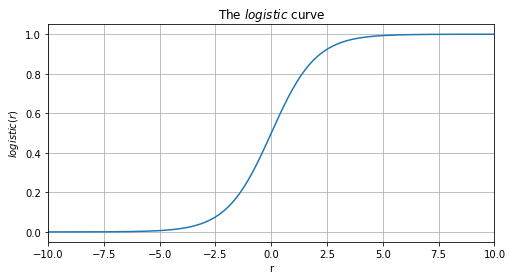

In [7]:
def logistic(r):
    return 1 / (1 + jnp.exp(-r))


b = 10
r = jnp.linspace(-b, b, 200)
_, ax = plt.subplots(figsize=FS)
plt.plot(r, logistic(r))
ax.grid()
_ = ax.set(xlabel="r", ylabel="$logistic(r)$", title="The $logistic$ curve")
_ = ax.set_xlim(-b, b)

In [8]:
def predict(c, w, X):
    return logistic(jnp.dot(X, w) + c)

In [9]:
def cost(c, w, X, y, eps=1e-14, lmbd=0.1):
    n = y.size
    p = predict(c, w, X)
    p = jnp.clip(p, eps, 1 - eps)  # bound the probabilities within (0,1) to avoid ln(0)
    return -jnp.sum(y * jnp.log(p) + (1 - y) * jnp.log(1 - p)) / n + 0.5 * lmbd * (
        jnp.dot(w, w) + c * c
    )

In [10]:
c_0 = 1.0
w_0 = 1.0e-5 * jnp.ones(n_feat)
print(cost(c_0, w_0, X_train_s, y_train))

1.0512689


# Batch Gradient Descent

In [11]:
%%time
n_iter = 1000
eta = 5e-2
tol = 1e-6
w = w_0
c = c_0
new_cost = float(cost(c, w, X_train_s, y_train))
cost_hist = [new_cost]
for i in range(n_iter):
    c_current = c
    c -= eta * grad(cost, argnums=0)(c_current, w, X_train_s, y_train)
    w -= eta * grad(cost, argnums=1)(c_current, w, X_train_s, y_train)
    new_cost = float(cost(c, w, X_train_s, y_train))
    cost_hist.append(new_cost)
    if (i > 20) and (i % 10 == 0):
        if jnp.abs(cost_hist[-1] - cost_hist[-20]) < tol:
            print(f"Exited loop at iteration {i}")
            break

Exited loop at iteration 840
CPU times: user 30.6 s, sys: 99.3 ms, total: 30.7 s
Wall time: 30.8 s


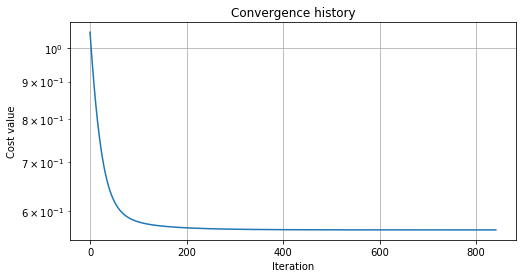

In [12]:
_, ax = plt.subplots(figsize=FS)
plt.semilogy(cost_hist)
ax.grid()
_ = ax.set(xlabel="Iteration", ylabel="Cost value", title="Convergence history")

In [13]:
y_pred_proba = predict(c, w, X_test_s)
y_pred = jnp.array(y_pred_proba)
y_pred = jnp.where(y_pred < 0.5, y_pred, 1.0)
y_pred = jnp.where(y_pred >= 0.5, y_pred, 0.0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       172
         1.0       0.00      0.00      0.00        78

    accuracy                           0.69       250
   macro avg       0.34      0.50      0.41       250
weighted avg       0.47      0.69      0.56       250



# Stochastic Gradient Descent

In [14]:
%%time
n_iter = X_train_s.shape[0]#1000
eta = 5e-2
tol = 1e-6
w = w_0
c = c_0
new_cost = float(cost(c, w, X_train_s[0], y_train[0]))
cost_hist = [new_cost]
for i in range(n_iter):
    c_current = c
    c -= eta * grad(cost, argnums=0)(c_current, w, X_train_s[i], y_train[i])
    w -= eta * grad(cost, argnums=1)(c_current, w, X_train_s[i], y_train[i])
    new_cost = float(cost(c, w, X_train_s, y_train))
    cost_hist.append(new_cost)
    if (i > 20) and (i % 10 == 0):
        if jnp.abs(cost_hist[-1] - cost_hist[-20]) < tol:
            print(f"Exited loop at iteration {i}")
            break

CPU times: user 30.2 s, sys: 66.7 ms, total: 30.3 s
Wall time: 30.5 s


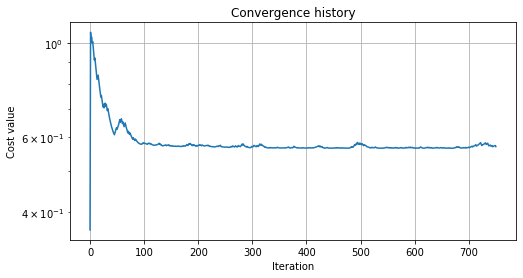

In [15]:
_, ax = plt.subplots(figsize=FS)
plt.semilogy(cost_hist)
ax.grid()
_ = ax.set(xlabel="Iteration", ylabel="Cost value", title="Convergence history")

In [16]:
y_pred_proba = predict(c, w, X_test_s)
y_pred = jnp.array(y_pred_proba)
y_pred = jnp.where(y_pred < 0.5, y_pred, 1.0)
y_pred = jnp.where(y_pred >= 0.5, y_pred, 0.0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       172
         1.0       0.00      0.00      0.00        78

    accuracy                           0.69       250
   macro avg       0.34      0.50      0.41       250
weighted avg       0.47      0.69      0.56       250



In [21]:
c, w

(DeviceArray(-0.29071796, dtype=float32, weak_type=True),
 DeviceArray([-0.4283252 ,  0.11431004, -0.9654911 ], dtype=float32))

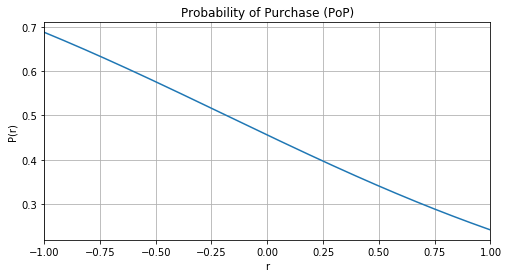

In [30]:
b = 1
r = jnp.linspace(-b, b, 200)
y = jnp.asarray([predict(c, w, jnp.asarray([0,1,p])) for p in r])
_, ax = plt.subplots(figsize=FS)
plt.plot(r, y)
ax.grid()
_ = ax.set(xlabel="r", ylabel="P(r)", title="Probability of Purchase (PoP)")
_ = ax.set_xlim(-b, b)